In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

In [7]:
cmp = 'viridis'
include_viridis = False
sv = False
dpi = 500
transparent = False
task = 'alpaca'

lora_lr=2e-4
alpha_lr = 2e-6

lora_b = 2
alpha_b = 2
layers = 12

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

In [8]:
paths = {
    'lora': f"./output/{task}/lr_{lora_lr}/batch_{lora_b}/lora/layers_0",
    'alpha': f"./output/{task}/lr_{alpha_lr}/batch_{alpha_b}/alpha/layers_{layers}"
}

In [9]:
dictionary = {
    "lora" :  {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
}

for key in dictionary.keys():
    path = paths[key]
    path = os.path.join(path, "finetune.npy")
    baseline = np.load(path, allow_pickle=True).item()
    for key2 in dictionary[key].keys():
        dictionary[key][key2].append(baseline[key2])
        dictionary[key][key2] = np.array(dictionary[key][key2])


(6758.412288, 19.98848)
Dataset          : alpaca
Method           : lora
Layers           : 0
Batch size       : 2
Learning Rate    : 0.0002
Forward time     : 3.431132733821869 min
Backward time    : 3.2627135515213013 min
Weight memory    : 27167.883264 MB
Optimizer memory : 159.90784 MB
Activation memory: 5737.52832 MB
Gradient memory  : 157.92384 MB
Input memory     : 0.008704 MB
Total memory     : 27405.769728 MB
Peak memory      : 37186.260992 MB


(6738.423808, 360.71424)
Dataset          : alpaca
Method           : alpha
Layers           : 12
Batch size       : 2
Learning Rate    : 2e-06
Forward time     : 1.2532102862993877 min
Backward time    : 3.5174551328023274 min
Weight memory    : 27087.929344 MB
Optimizer memory : 2885.71392 MB
Activation memory: 4503.892992 MB
Gradient memory  : 1525.43488 MB
Input memory     : 0.008704 MB
Total memory     : 30056.229888 MB
Peak memory      : 41205.979136 MB




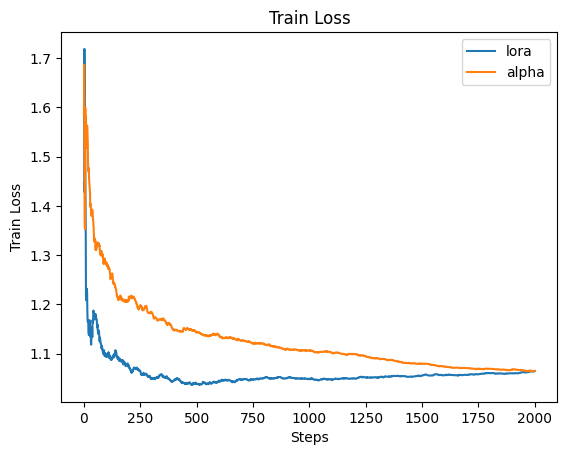

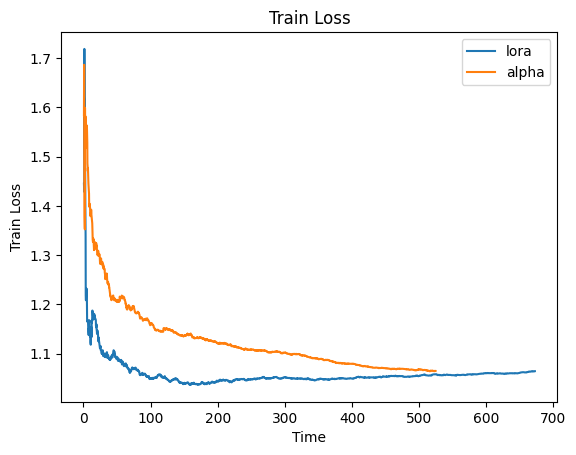

In [10]:
# load memlog.log from lora_path and alpha_path and print it

for key in dictionary.keys():
    memlog = os.path.join(paths[key], "memlog.log")
    with open(memlog, 'r') as f:
        memlog = f.readlines()
    memlog = memlog[4:]
    memlog = "".join(memlog)
    print(memlog, end='')

for key in dictionary.keys():
    plt.plot(dictionary[key]['train_loss'][0], label=key)
    plt.xlabel("Steps")
    plt.ylabel("Train Loss")
plt.legend()
plt.title("Train Loss")
plt.show()


for key in dictionary.keys():
    plt.plot(dictionary[key]['time'][0],dictionary[key]['train_loss'][0], label=key)
    plt.xlabel("Time")
    plt.ylabel("Train Loss")
plt.legend()
plt.title("Train Loss")
plt.show()